In [73]:
%matplotlib inline
from matplotlib import pyplot as plt

import autograd.numpy as np
from autograd import grad 

# element-wise gradient is a standard-alone function in v1.2
from autograd import elementwise_grad as egrad

import autograd.numpy.random as npr
from autograd.misc.flatten import flatten_func, flatten

from scipy.integrate import odeint # for comparision
from scipy.optimize import minimize

In [74]:
import scipy
scipy.__version__

'0.19.1'

# Scipy solver for different y0

## define function

In [75]:
def f(t, y):
    '''
        dy/dt = f(t, y)
        This is f() function on the right
    '''    
    return -y*np.sin(t) #-y + np.sin(t)

f_yt = lambda y,t: f(t, y) # this is for odeint

## Solve for different y0

In [76]:
t = np.linspace(0, 6, 20).reshape(-1,1)
y0_list = np.arange(0, 10, 1)
y_list = [] # record solution
dydt_list = [] # record gradient

for y0 in y0_list:
    y = odeint(f_yt, y0=y0, t=t.ravel())
    
    y_list.append(y.ravel())
    dydt_list.append(f(t, y).ravel())
    
y_list = np.array(y_list)
dydt_list = np.array(dydt_list)
y_list.shape, dydt_list.shape # [y0, t]

((10, 20), (10, 20))

## Dependence on t

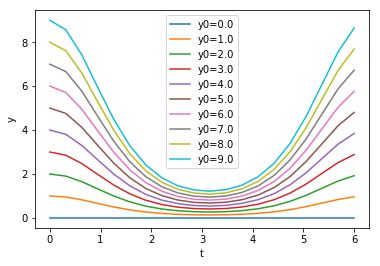

In [77]:
for i,y in enumerate(y_list):
    plt.plot(t, y, label=f'y0={y0_list[i]:.1f}')
    
plt.legend()
plt.xlabel('t');plt.ylabel('y');

(10, 20)

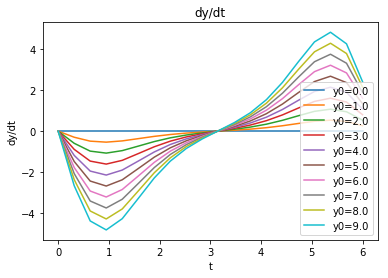

In [78]:
for i, dydt in enumerate(dydt_list):
    plt.plot(t, dydt, label=f'y0={y0_list[i]:.1f}')
    
plt.legend()
plt.xlabel('t');plt.ylabel('dy/dt');
plt.title('dy/dt');

y_list = np.array(y_list)
y_list.shape # [y0, t]

## Dependence on y0

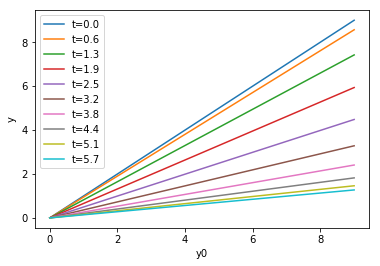

In [79]:
for i,ti in enumerate(t[::2]):
    plt.plot(y0_list, y_list[:,i], label=f't={ti[0]:.1f}')
    
plt.xlabel('y0');plt.ylabel('y');
plt.legend()

## 2D heatmap plot

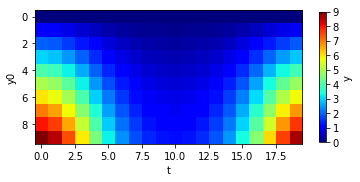

In [80]:
plt.imshow(y_list, cmap='jet')
plt.colorbar(shrink=0.6).set_label('y')
plt.xlabel('t');plt.ylabel('y0');

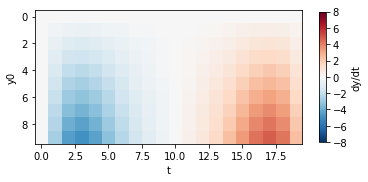

In [81]:
plt.imshow(dydt_list, cmap='RdBu_r', vmax=8, vmin=-8)
plt.colorbar(shrink=0.6).set_label('dy/dt')
plt.xlabel('t');plt.ylabel('y0');

# Build NN with x=(t, y0) as input

## NN weights

In [82]:
def init_weights(n_in=2, n_hidden=10, n_out=1):
    W1 = npr.randn(n_in, n_hidden)
    b1 = np.zeros(n_hidden)
    W2 = npr.randn(n_hidden, n_out)
    b2 = np.zeros(n_out)
    params = [W1, b1, W2, b2]
    return params

params = init_weights()
print([ p.shape for p in params ])

[(2, 10), (10,), (10, 1), (1,)]


## NN Prediction

In [83]:
def predict(params, t_sample, y0_sample, act=np.tanh):
    W1, b1, W2, b2 = params
    
    x = np.hstack([t_sample, y0_sample]) # n_sample * n_in (n_in = 2 here)
    
    a = act(np.dot(x, W1) + b1)
    y = np.dot(a, W2) + b2
    
    phi = y0_sample + t_sample*y
    
    return phi

In [84]:
t_mesh, y0_mesh = np.meshgrid(t, y0_list)
t_sample = t_mesh.reshape(-1,1)
y0_sample = y0_mesh.reshape(-1,1)

In [85]:
y_pred = predict(params, t_sample, y0_sample)
y_pred = y_pred.reshape(y0_mesh.shape)
y_pred.shape # [y0, t]

(10, 20)

In [86]:
y_pred[:,0] # should be y0

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

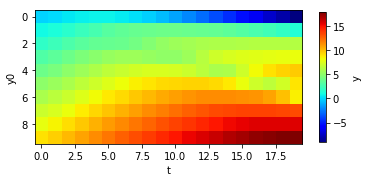

In [87]:
plt.imshow(y_pred, cmap='jet')
plt.colorbar(shrink=0.6).set_label('y')
plt.xlabel('t');plt.ylabel('y0');

## Take gradient w.r.t `t`

In [88]:
predict_dt = egrad(predict, argnum=1) # grad w.r.t t

In [89]:
dydt_pred = predict_dt(params, t_sample, y0_sample)
dydt_pred.shape

(200, 1)

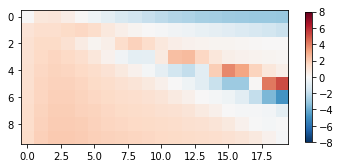

In [90]:
plt.imshow( dydt_pred.reshape(y0_mesh.shape), 
            cmap='RdBu_r', vmax=8, vmin=-8)
plt.colorbar(shrink=0.6)

## NN loss

In [91]:
f_pred = f(t_sample, y0_sample)

In [92]:
def loss_func(params, t_sample, y0_sample):
    y_pred =  predict(params, t_sample, y0_sample)
    dydt_pred = predict_dt(params, t_sample, y0_sample)
    f_pred = f(t_sample, y_pred)
    return np.sum( (dydt_pred-f_pred)**2 )

In [93]:
loss_func(params, t_sample, y0_sample)

9562.1134181945054

# Training NN

## Flatten NN weights

In [94]:
flattened_params, unflat_func = flatten(params)

In [95]:
def loss_wrap(flattened_params, t_sample, y0_sample):
    params = unflat_func(flattened_params) # recover
    return loss_func(params, t_sample, y0_sample)

grad_wrap = grad(loss_wrap)

In [96]:
loss_wrap(flattened_params, t_sample, y0_sample)

9562.1134181945054

## Send to scipy optimizer

### Make partitial function

In [97]:
def loss_part(flattened_params):
    '''make partial function. 
    Use this simple method because
    autograd or scipy does not like functool.partial'''
    # warning: global t is used
    return loss_wrap(flattened_params, t_sample, y0_sample)

In [98]:
loss_part(flattened_params)

9562.1134181945054

### Optional: provide gradient by autograd

In [99]:
loss_part_grad = grad(loss_part) # jacobian

In [100]:
loss_part_grad(flattened_params).shape

(41,)

## Start training

In [101]:
# don't print overflow warning
import warnings
warnings.filterwarnings("ignore")

In [102]:
# repeat with different initial weights
params = init_weights() 
flattened_params, _ = flatten(params)

In [148]:
flag = 0

In [149]:
def print_loss(x):
    global flag 
    flag += 1
    if flag %100 == 0:  
        print("loss: ", loss_part(x))

In [150]:
%%time
o = minimize(loss_part, x0=flattened_params, 
             jac=loss_part_grad, method="BFGS",
             options = {'disp': True, 'maxiter': 1000}, callback = print_loss)

loss:  2.3024680261
loss:  1.31694996936
loss:  0.977335294171
loss:  0.570726852815
loss:  0.180789677781
loss:  0.087746309037
loss:  0.0609620616438
loss:  0.0514191632673
loss:  0.0352547041749
loss:  0.0281098261758
         Current function value: 0.028110
         Iterations: 1000
         Function evaluations: 1080
         Gradient evaluations: 1080
CPU times: user 3.88 s, sys: 17.3 ms, total: 3.89 s
Wall time: 3.9 s


In [56]:
print(o.fun, o.njev, o.nfev, '\n', o.message)

0.003773492876217726 2880 2892 
 Desired error not necessarily achieved due to precision loss.


In [57]:
loss_part(o.x)

0.0037734928762177258

## Make new prediction

### Function value

In [58]:
y_pred = predict(unflat_func(o.x), t_sample, y0_sample)
y_pred = y_pred.reshape(y0_mesh.shape)
y_pred.shape # [y0, t]

(10, 20)

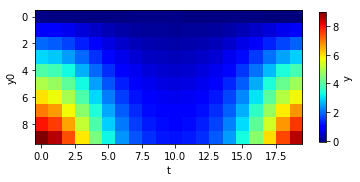

In [59]:
plt.imshow(y_pred, cmap='jet')
plt.colorbar(shrink=0.6).set_label('y')
plt.xlabel('t');plt.ylabel('y0');

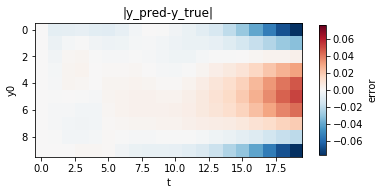

In [60]:
error = y_pred-y_list
maxerror = np.abs(error).max()

plt.imshow(error, cmap='RdBu_r', vmin=-maxerror, vmax=maxerror)
plt.colorbar(shrink=0.6).set_label('error')
plt.title('|y_pred-y_true|')
plt.xlabel('t');plt.ylabel('y0');

### dydt

In [61]:
dydt_pred = predict_dt(unflat_func(o.x), t_sample, y0_sample)
dydt_pred = dydt_pred.reshape(y0_mesh.shape)
dydt_pred.shape # [y0, t]

(10, 20)

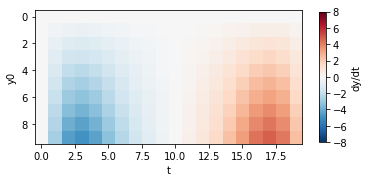

In [62]:
plt.imshow(dydt_pred, cmap='RdBu_r', vmax=8, vmin=-8)
plt.colorbar(shrink=0.6).set_label('dy/dt')
plt.xlabel('t');plt.ylabel('y0');

# Generalize to new y0

In [63]:
y0_test = 8

In [64]:
ytrue_test = odeint(f_yt, y0_test, t=t.ravel())

In [65]:
ypred_test = predict(unflat_func(o.x), t, y0_test*np.ones_like(t))

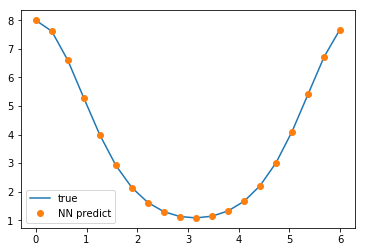

In [66]:
plt.plot(t, ytrue_test, label='true')
plt.plot(t, ypred_test, 'o', label='NN predict')
plt.legend()